# Simulated Datasets with different source voltages and same filters

In this notebook, we provide an example about how to use xspec forward model to generate the simulated datset with 3 different source voltages and a same filter.

In [1]:
# Basic Packages
import os
import numpy as np
import matplotlib.pyplot as plt
import svmbir
import h5py

from xspec.chem_consts import get_lin_att_c_vs_E
from xspec import calc_forward_matrix
from xspec._utils import Gen_Circle
import spekpy as sp  # Import SpekPy
from xspec.defs import Material
from xspec.chem_consts._periodictabledata import density
from xspec.models import *

In [15]:
min_simkV = 30
max_simkV = 200

## A. Calculate forward matrix
Detail explanation can be found in examples/notebook/user_forward_projector.ipynb

In [16]:
# Scanned cylinders
materials = ['V', 'Al', 'Ti', 'Mg']
mat_density = [density['%s' % formula] for formula in materials]
energies = np.linspace(1, max_simkV, max_simkV) # Define energies bins from 1 kV to 160 kV with step size 1 kV.
lac_vs_E_list = []

for i in range(len(materials)):
    formula = materials[i]
    den = mat_density[i]
    lac_vs_E_list.append(get_lin_att_c_vs_E(den, formula, energies))
    

In [17]:
# FOV is about 10 mm * 10 mm
nchanl = 1024
rsize = 0.01  # mm

# 4 cylinders with 1mm radius are evenly distributed on a circle with 3mm radius.
Radius = [1 for _ in range(len(materials))]
arrange_with_radius = 3 
centers = [[np.sin(rad_angle) * arrange_with_radius, np.cos(rad_angle) * arrange_with_radius]
		   for rad_angle in np.linspace(-np.pi / 2, -np.pi / 2 + np.pi * 2, len(materials), endpoint=False)]

# Each mask represents a homogenous cylinder.
mask_list = []
for mat_id, mat in enumerate(materials):
	circle = Gen_Circle((nchanl, nchanl), (rsize, rsize))
	# Use np.newaxis to convert 2D array to 3D.
	mask_list.append(circle.generate_mask(Radius[mat_id], centers[mat_id])[np.newaxis])
    

In [18]:
class fw_projector:
    """A class for forward projection using SVMBIR."""

    def __init__(self, angles, num_channels, delta_pixel=1):
        """
        Initializes the forward projector with specified geometric parameters.

        Parameters:
            angles (array): Array of projection angles.
            num_channels (int): Number of detector channels.
            delta_pixel (float, optional): Size of a pixel, defaults to 1.
        """
        self.angles = angles
        self.num_channels = num_channels
        self.delta_pixel = delta_pixel

    def forward(self, mask):
        """
        Computes the projection of a given mask.

        Parameters:
            mask (numpy.ndarray): 3D mask of the object to be projected.

        Returns:
            numpy.ndarray: The computed projection of the mask.
        """
        projections = svmbir.project(mask, self.angles, self.num_channels) * self.delta_pixel
        return projections
    
angles = np.linspace(-np.pi/2, np.pi, 40, endpoint=False)
projector = fw_projector(angles, num_channels=1024, delta_pixel=0.01)

In [19]:
spec_F = calc_forward_matrix(mask_list, lac_vs_E_list, projector)

Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/fa02df7dd8cb1ddb5e4d.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/fa02df7dd8cb1ddb5e4d.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/fa02df7dd8cb1ddb5e4d.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/fa02df7dd8cb1ddb5e4d.2Dsvmatrix


## B.Generate ground truth X-ray spectral energy response
Detail explanation can be found in examples/notebook/configure_spectral_models.ipynb


Running demo script (10 mAs, 100 cm)

Finished!


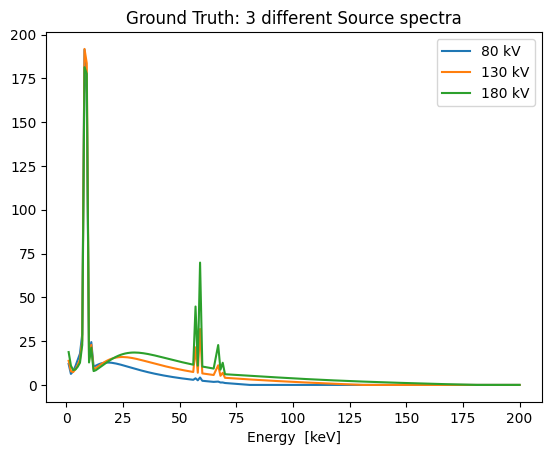

In [20]:
simkV_list = np.linspace(min_simkV, max_simkV, (max_simkV-min_simkV)//10+1, endpoint=True).astype('int')

takeoff_angle = 20
ref_takeoff_angle = 11
# Energy bins.
energies = np.linspace(1, max_simkV, max_simkV)

# Use Spekpy to generate a source spectra dictionary.
src_spec_list = []

print('\nRunning demo script (10 mAs, 100 cm)\n')
for simkV in simkV_list:
    s = sp.Spek(kvp=simkV + 1, th=ref_takeoff_angle, dk=1, mas=1, char=True)  # Create the spectrum model
    k, phi_k = s.get_spectrum(edges=True)  # Get arrays of energy & fluence spectrum
    phi_k = phi_k * ((rsize / 10) ** 2)
    src_spec = np.zeros((max_simkV))
    src_spec[:simkV] = phi_k[::2]
    src_spec_list.append(src_spec)

print('\nFinished!\n')

# A dictionary of source spectra with source voltage from 30 kV to 200 kV
src_spec_list = np.array(src_spec_list)

voltage_list = [80.0, 130.0, 180.0]  # kV
sources = [Reflection_Source(voltage=(voltage, None, None), takeoff_angle=(20, None, None), single_takeoff_angle=True) for
    voltage in voltage_list]
for src_i, source in enumerate(sources):
    source.set_src_spec_list(src_spec_list, simkV_list, ref_takeoff_angle)
    plt.plot(energies, source(energies), label='%d kV'%voltage_list[src_i])
plt.title('Ground Truth: 3 different Source spectra')
plt.xlabel('Energy  [keV]')
plt.legend()

Text(0.5, 0, 'Energy  [keV]')

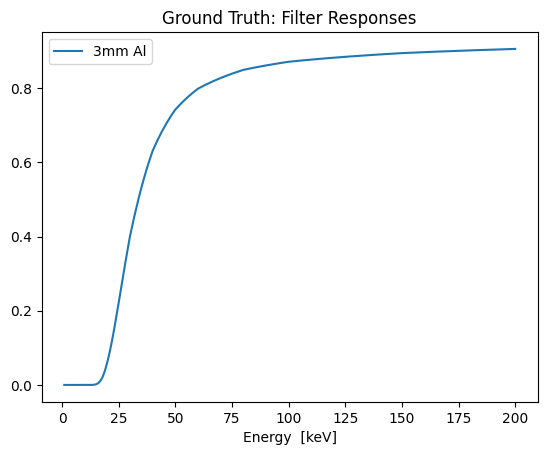

In [21]:
psb_fltr_mat = [Material(formula='Al', density=2.702)]
filter_1 = Filter(psb_fltr_mat, thickness=(3, None, None))
plt.plot(energies, filter_1(energies), label='3mm Al')
plt.title('Ground Truth: Filter Responses')
plt.legend()
plt.xlabel('Energy  [keV]')

Text(0.5, 0, 'Energy  [keV]')

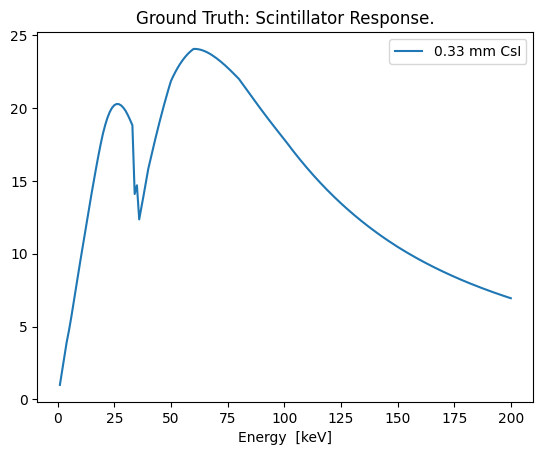

In [22]:
psb_scint_mat = [Material(formula='CsI', density=4.51)]
scintillator_1 = Scintillator(materials=psb_scint_mat[0:1], thickness=(0.33, None, None))
plt.plot(energies, scintillator_1(energies), label='0.33 mm CsI')
plt.title('Ground Truth: Scintillator Response.')
plt.legend()
plt.xlabel('Energy  [keV]')

Text(0.5, 0, 'Energy  [keV]')

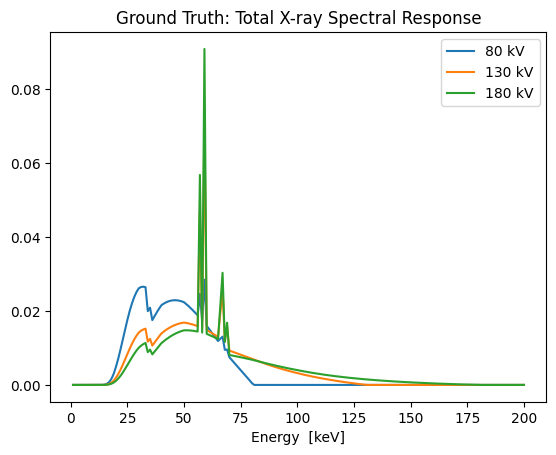

In [23]:
gt_spec_list = [(source(energies) * filter_1(energies)  * scintillator_1(energies)).numpy() for source in sources]
for spec_i, gt_spec in enumerate(gt_spec_list):
    plt.plot(energies, gt_spec / np.trapz(gt_spec, energies), label='%d kV'%voltage_list[spec_i])
plt.legend()
plt.title('Ground Truth: Total X-ray Spectral Response')
plt.xlabel('Energy  [keV]')

## C. Generate simulated datasets with above 3 reponses.

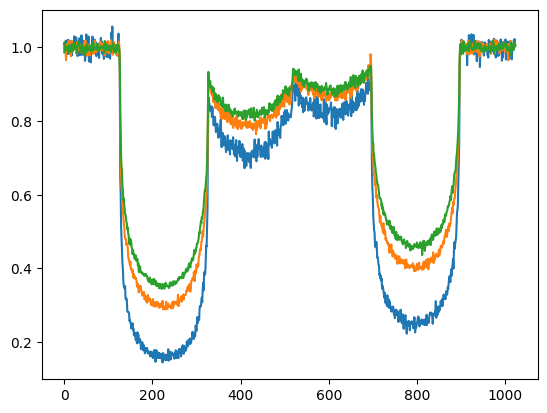

In [24]:
os.makedirs('../data/',exist_ok=True)
datasets = []
label_list = ['80 kV', '130 kV', '180 kV']

for case_i, gt_spec in zip(np.arange(len(gt_spec_list)), gt_spec_list):
    spec_F_train_list = []
    trans_list = []
    
    # Add poisson noise before reaching detector/scintillator.
    trans = np.trapz(spec_F * gt_spec, energies, axis=-1)
    trans_0 = np.trapz(gt_spec, energies, axis=-1)
    trans_noise = np.random.poisson(trans).astype(np.float64)
    trans_noise /= trans_0   
        
    
     # Add poisson noise before reaching detector/scintillator.
    trans = np.trapz(spec_F * gt_spec, energies, axis=-1)
    trans_0 = np.trapz(gt_spec, energies, axis=-1)
    trans_noise = np.random.poisson(trans).astype(np.float64)
    trans_noise /= trans_0

    # Store noiseless transmission data and forward matrix.
    trans_list.append(trans_noise)
    spec_F_train = spec_F.reshape((-1, spec_F.shape[-1]))
    spec_F_train_list.append(spec_F_train)
    spec_F_train_list = np.array(spec_F_train_list)
    trans_list = np.array(trans_list)
    plt.plot(trans_list[0][16, 0], label=label_list[case_i])
    d = {
        'measurement': trans_list,
        'forward_mat': spec_F_train_list,
        'source': sources[case_i],
        'filter': filter_1,
        'scintillator': scintillator_1,
    }
    datasets.append(d)
    
with open('../data/sim_3v1f1s_dataset.npy', 'wb') as f:
    np.save(f, datasets,allow_pickle=True)       